# Notebook 2: Tire Degradation Rules Implementation

This notebook focuses on implementing the rule set related to tire degradation for our F1 Strategy Engine. These rules are crucial for race strategy as they determine when a car should pit based on tire performance analysis.

## Overview of Degradation Rules

We'll implement three core rules:

1. **High Degradation Rate Pit Stop**
   - IF (DegradationRate > 0.15 AND TyreAge > 10)
   - THEN recommend priority pit stop
   - CONFIDENCE: 0.85

2. **Stint Extension for Low Degradation**
   - IF (DegradationRate < 0.08 AND TyreAge > 12 AND Position < 5)
   - THEN recommend extending current stint
   - CONFIDENCE: 0.75

3. **Early Degradation Warning**
   - IF (DegradationRate increases by more than 0.03 in 3 consecutive laps)
   - THEN recommend pit stop preparation
   - CONFIDENCE: 0.7

Each rule handles specific aspects of tire degradation strategy that F1 teams consider during races.

---

## 1. Importing necessary Libraries

In [22]:
# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import sys

# Import Experta components
from experta import Rule, NOT, OR, AND, AS, MATCH, TEST, EXISTS
from experta import DefFacts, Fact, Field, KnowledgeEngine


####################### Import Custom Fact Classes ###################
from utils.N01_agent_setup import (
    TelemetryFact,
    DegradationFact,
    RaceStatusFact,
    StrategyRecommendation,
    F1StrategyEngine,
    transform_degradation_prediction
)
 
# Configuring plots 

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_context("notebook", font_scale= 1.2)

print("Libraries and fact classes loaded successfully.")

Libraries and fact classes loaded successfully.


---

In [23]:
# Load and prepare tire degradation data
def load_degradation_data(file_path='../../outputs/week5/tire_degradation_fuel_adjusted.csv'):
    """
    Load real tire degradation data and prepare it for rule evaluation
    
    Args:
        file_path: Path to the degradation data CSV file
        
    Returns:
        DataFrame with processed tire degradation data
    """
    df = pd.read_csv(file_path)
    print(f"Successfully loaded data from {file_path}")
    
    # Convert float columns to integers where appropriate
    integer_columns = ['Position', 'TyreAge', 'DriverNumber', 'CompoundID', 'TeamID']
    for col in integer_columns:
        if col in df.columns:
            df[col] = df[col].astype(int)
    
    # Sort data for consistency
    df = df.sort_values(['DriverNumber', 'Stint', 'TyreAge'])
    
    # Calculate race lap by accumulating TyreAge across stints
    # First, get the maximum TyreAge for each completed stint
    max_age_by_stint = df.groupby(['DriverNumber', 'Stint'])['TyreAge'].max().reset_index()
    max_age_by_stint = max_age_by_stint.rename(columns={'TyreAge': 'StintLength'})
    
    # Create a lookup for previous stint lengths
    stint_lengths = {}
    for driver in df['DriverNumber'].unique():
        driver_stints = max_age_by_stint[max_age_by_stint['DriverNumber'] == driver]
        
        # Calculate cumulative stint lengths
        cumulative_lengths = [0]  # Start with 0 for the first stint
        for i in range(len(driver_stints) - 1):
            cumulative_lengths.append(
                cumulative_lengths[-1] + driver_stints.iloc[i]['StintLength']
            )
        
        # Store in dictionary
        stint_lengths[driver] = {
            stint: length for stint, length in zip(
                driver_stints['Stint'], cumulative_lengths
            )
        }
    
    # Function to calculate race lap
    def calculate_race_lap(row):
        driver = row['DriverNumber']
        stint = row['Stint']
        tyre_age = row['TyreAge']
        
        # Get the starting lap for this stint
        start_lap = stint_lengths.get(driver, {}).get(stint, 0)
        
        # Add current TyreAge to get race lap
        return start_lap + tyre_age
    
    # Apply function to calculate race lap
    df['RaceLap'] = df.apply(calculate_race_lap, axis=1)
    
    # For each driver-stint combination, calculate previous degradation rates
    # This will be useful for Rule 3 (Early Degradation Warning)
    def get_previous_rates(group, n=3):
        """Get previous n degradation rates for each row in the group"""
        rates = []
        for i in range(len(group)):
            if i < n:
                # Not enough previous data
                rates.append(group.iloc[:i+1]['DegradationRate'].tolist())
            else:
                # Get last n rates including current
                rates.append(group.iloc[i-n+1:i+1]['DegradationRate'].tolist())
        return rates
    
    # Apply function to each driver-stint group
    df['PreviousRates'] = df.groupby(['DriverNumber', 'Stint']).apply(
        lambda x: get_previous_rates(x)
    ).explode().tolist()
    
    return df



In [24]:
# Load the data
degradation_data = load_degradation_data()

# Display sample of the data
print("Loaded degradation data:")
display(degradation_data.head())



Successfully loaded data from ../../outputs/week5/tire_degradation_fuel_adjusted.csv
Loaded degradation data:


C:\Users\victo\AppData\Local\Temp\ipykernel_28256\4014458323.py:78: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['PreviousRates'] = df.groupby(['DriverNumber', 'Stint']).apply(


,Stint,SpeedI1,SpeedI2,SpeedFL,SpeedST,Position,LapsSincePitStop,DRSUsed,TeamID,CompoundID,TyreAge,FuelLoad,DriverNumber,FuelAdjustedLapTime,FuelAdjustedDegPercent,DegradationRate,RaceLap,PreviousRates
0,1.0,256.0,261.0,276.0,275.0,1,1.0,0,9,2,1,0.9848,1,83.935,0.000000,0.000000,1.0,[0.0]
16,1.0,252.0,257.0,276.0,295.0,1,2.0,0,9,2,2,0.9697,1,80.457,-4.143683,-3.941625,2.0,"[0.0, -3.941624999999988]"
20,1.0,249.0,256.0,276.0,297.0,1,3.0,0,9,2,3,0.9545,1,80.609,-3.962590,0.232092,3.0,"[0.0, -3.941624999999988, 0.2320916666666619]"
48,1.0,255.0,256.0,276.0,300.0,1,4.0,0,9,2,4,0.9394,1,80.511,-4.079347,0.073592,4.0,"[-3.941624999999988, 0.2320916666666619, 0.073..."
50,1.0,254.0,256.0,277.0,301.0,1,5.0,0,9,2,5,0.9242,1,80.503,-4.088878,0.007353,5.0,"[0.2320916666666619, 0.0735921568627446, 0.007..."


---

### Chossoing thresholds for degradation

DegradationRate statistics:


count    1180.000000
mean        0.000665
std         0.591501
min        -3.941625
25%        -0.050319
50%         0.065385
75%         0.167878
max         2.113000
Name: DegradationRate, dtype: float64


Statistics for positive degradation values only:


count    688.000000
mean       0.248009
std        0.296526
min        0.007353
25%        0.111207
50%        0.148136
75%        0.280840
max        2.113000
Name: DegradationRate, dtype: float64

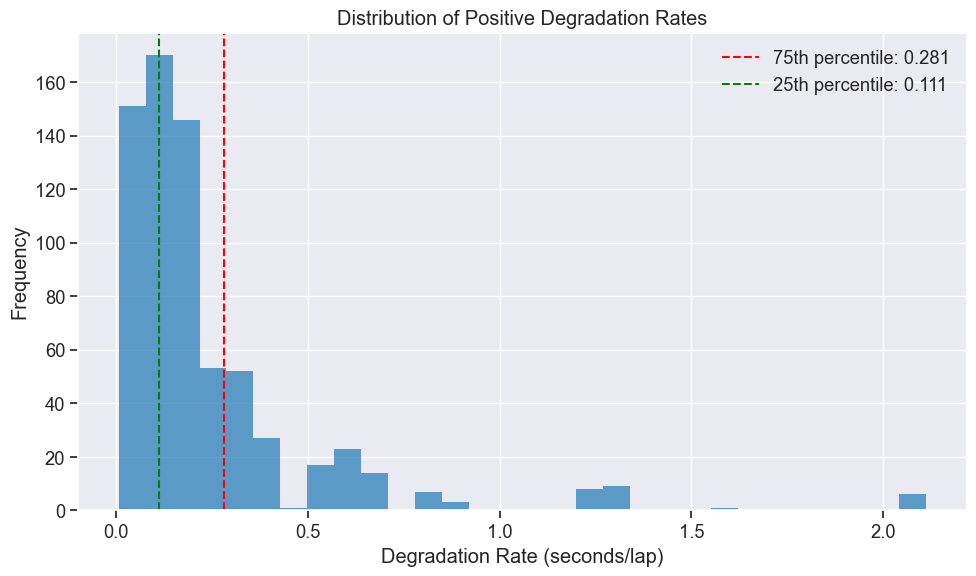


Suggested thresholds based on data distribution:
High Degradation Threshold: 0.281 seconds/lap
Low Degradation Threshold: 0.111 seconds/lap


In [25]:
# Analyze DegradationRate distribution to set appropriate thresholds
print("DegradationRate statistics:")
display(degradation_data['DegradationRate'].describe())

# Distribution of positive degradation values (actual degradation)
positive_deg = degradation_data[degradation_data['DegradationRate'] > 0]['DegradationRate']
print("\nStatistics for positive degradation values only:")
display(positive_deg.describe())

# Visualize the distribution
plt.figure(figsize=(10, 6))
plt.hist(positive_deg, bins=30, alpha=0.7)
plt.axvline(positive_deg.quantile(0.75), color='r', linestyle='--', 
           label=f'75th percentile: {positive_deg.quantile(0.75):.3f}')
plt.axvline(positive_deg.quantile(0.25), color='g', linestyle='--',
           label=f'25th percentile: {positive_deg.quantile(0.25):.3f}')
plt.xlabel('Degradation Rate (seconds/lap)')
plt.ylabel('Frequency')
plt.title('Distribution of Positive Degradation Rates')
plt.legend()
plt.tight_layout()
plt.show()

# Suggested thresholds based on data percentiles
high_degradation_threshold = positive_deg.quantile(0.75)  # 75th percentile
low_degradation_threshold = positive_deg.quantile(0.25)   # 25th percentile

print(f"\nSuggested thresholds based on data distribution:")
print(f"High Degradation Threshold: {high_degradation_threshold:.3f} seconds/lap")
print(f"Low Degradation Threshold: {low_degradation_threshold:.3f} seconds/lap")

---

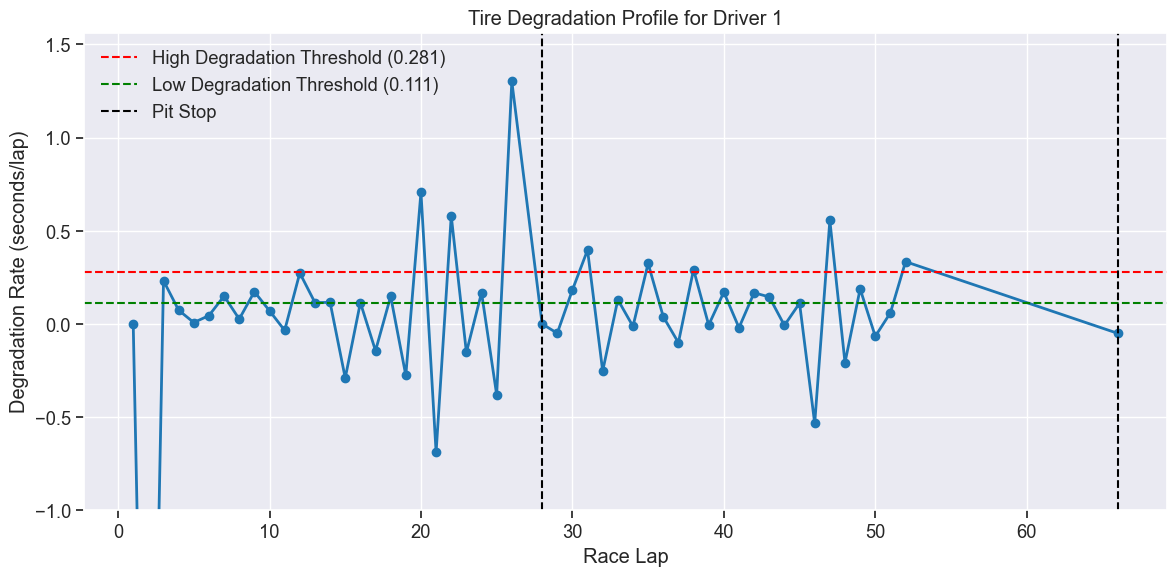

In [28]:
# Plot degradation for a sample driver across race laps
sample_driver = degradation_data['DriverNumber'].unique()[0]
driver_data = degradation_data[degradation_data['DriverNumber'] == sample_driver]

# Visualize degradation with the correct thresholds and limited y-axis
plt.figure(figsize=(12, 6))
plt.plot(driver_data['RaceLap'], driver_data['DegradationRate'], 'o-', linewidth=2)
plt.axhline(y=0.281, color='r', linestyle='--', label='High Degradation Threshold (0.281)')
plt.axhline(y=0.111, color='g', linestyle='--', label='Low Degradation Threshold (0.111)')

# Mark stint changes
stint_changes = []
for i in range(1, len(driver_data)):
    if driver_data.iloc[i]['Stint'] != driver_data.iloc[i-1]['Stint']:
        stint_changes.append(driver_data.iloc[i]['RaceLap'])

for lap in stint_changes:
    plt.axvline(x=lap, color='k', linestyle='--', label='Pit Stop' if 'Pit Stop' not in plt.gca().get_legend_handles_labels()[1] else "")

# Establecer límites del eje Y - esto cortará valores por debajo de -1
plt.ylim(bottom=-1)

plt.xlabel('Race Lap')
plt.ylabel('Degradation Rate (seconds/lap)')
plt.title(f'Tire Degradation Profile for Driver {sample_driver}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()